[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [6]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
chat_log = [AIMessage(f"So you said you were researching reading people?", name="Bot")]
chat_log.append(HumanMessage(f"Yes, I was. But what's something else I should learn about?", name="Lance"))

for m in chat_log:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching reading people?
================================ Human Message =================================
Name: Lance

Yes, I was. But what's something else I should learn about?


Recall we can pass them to a chat model.

In [7]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-mini")
llm.invoke(chat_log)

AIMessage(content='Nice — here are several useful directions you could pick next, with why they matter and a quick way to get started. Pick one that matches your goals (relationships, influence, job performance, safety, etc.).\n\n1. Emotional intelligence (EQ)\n   - Why: Helps you understand and manage your own emotions and respond better to others.\n   - Start: Read Daniel Goleman’s Emotional Intelligence or take a short online EQ assessment and practice labeling your emotions daily.\n\n2. Active listening & conversational skills\n   - Why: Makes “reading people” much more accurate and builds trust.\n   - Start: Practice reflective listening (repeat back meaning, not words) in one conversation per day; watch short videos on active listening.\n\n3. Nonverbal communication / body language\n   - Why: Gives context to speech and emotional states.\n   - Start: Read Joe Navarro’s What Every BODY is Saying and do a week-long observation exercise (note posture, gestures, proxemics in neutral 

We can run our chat model in a simple graph with `MessagesState`.

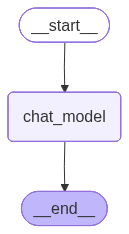

In [10]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
output = graph.invoke({'messages': chat_log})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching reading people?
================================ Human Message =================================
Name: Lance

Yes, I was. But what's something else I should learn about?
================================== Ai Message ==================================

Good question — here are several useful, high-impact areas you could learn next, with why each is valuable and a quick way to get started. Pick any that sounds interesting and I’ll give a tailored plan.

1) Learning how to learn (meta-learning)
- Why: Makes every future skill easier to acquire.
- Start: Read "Make It Stick" or follow a short course on spaced repetition, active recall, and deliberate practice (e.g., Coursera/edX).

2) Emotional intelligence (EQ) & active listening
- Why: Deepens relationships and boosts leadership; pairs well with reading people.
- Start: Practice reflective listening in daily conver

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

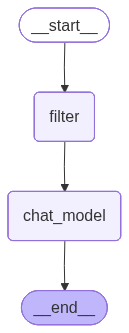

In [12]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
# Message list with a preamble
chat_track = [AIMessage("Hi.", name="Bot", id="1")]
chat_track.append(HumanMessage("Hi.", name="Lance", id="2"))
chat_track.append(AIMessage("So you said you were researching reading people?", name="Bot", id="3"))
chat_track.append(HumanMessage("Yes, I was. But what's something else I should learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': chat_track})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching reading people?
================================ Human Message =================================
Name: Lance

Yes, I was. But what's something else I should learn about?
================================== Ai Message ==================================

Good — here are several useful directions you could learn next, organized by type. Each item has a short why and a quick way to get started.

Social / interpersonal
- Negotiation and persuasion — helps you get better outcomes in work and relationships. Start: read Never Split the Difference (Chris Voss) and practice small negotiations (prices, schedules).
- Active listening & conflict resolution — makes reading people more actionable and builds trust. Start: practice reflective listening (repeat/paraphrase), take a short conflict-resolution or counseling-skills workshop.

Thinking & decision-making
- Mental models &

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

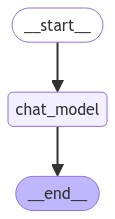

In [11]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [16]:
chat_track.append(output['messages'][-1])
chat_track.append(HumanMessage(f"Tell me more about Negotiation and Persuasion!", name="Lance"))

In [17]:
for m in chat_track:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching reading people?
================================ Human Message =================================
Name: Lance

Yes, I was. But what's something else I should learn about?
================================== Ai Message ==================================

Good — here are several useful directions you could learn next, organized by type. Each item has a short why and a quick way to get started.

Social / interpersonal
- Negotiation and persuasion — helps you get better outcomes in work and relationships. Start: read Never Split the Difference (Chris Voss) and practice small negotiations (prices, schedules).
- Active listening & conflict resolution — makes reading people more ac

In [18]:
# Invoke, using message filtering
output = graph.invoke({'messages': chat_track})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Tell me more about Narwhals!
================================ Human Message =================================
Name: Lance

Tell me more about Negotiation and Persuasion!
================================== Ai Message ==================================

Nice — two fun topics. I’ll give a compact, useful summary of each: narwhals first, then negotiation & persuasion (principles, tactics, and practical tips you can use).

Narwhals (Monodon monoceros)
- What they are: Medium-sized Arctic toothed whales best known for the long spiral “tusk” protruding from the head of most males (sometimes females). They are sometimes called the “unicorns of the sea.”
- Range & habitat: Arctic waters around Greenland, Canada (particularly Nunavut), and parts of Russia. They migrate seasonally between coastal summering areas (fjords) and offshore wintering in pack ice.
- Size & lifespan: Adults are roughly 3–5 m long

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

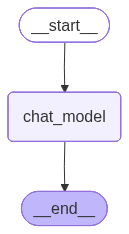

In [19]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
chat_track.append(output['messages'][-1])
chat_track.append(HumanMessage(f"Tell me how to Critical Think!", name="Lance"))

In [25]:
# Example of trimming messages
trim_messages(
            chat_track,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me how to Critical Think!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [26]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': chat_track})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r